In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import statistics
cmd_folder = os.getenv("SESNPATH") + "/utils"
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from templutils import *
from itertools import combinations


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Setting up

In [2]:
# Reading in the list of bands
su = setupvars()
bands = su.bands

In [3]:
# Use band+p for bands ugri
bands_w_p = [(b + 'p' if b in ['u', 'r', 'i'] else b) for b in bands]

# List of subtypes
types = ['IIb', 'Ib', 'Ibn', 'Ic', 'Ic-bl', 'Ib-c']

In [4]:
# Every combination of 2 bands from the list of all bands
bands_combo = list(combinations(bands_w_p, 2))

## Reading in the file with all data + GP fits

In [5]:
# Read in the file containing all data + GP fits

output_directory = os.getenv("SESNPATH") + "maketemplates/data/"
all_sne = pkl.load(open(output_directory + "all_data.pkl", "rb"))

### Looking at an example SN light curve and its GP fit

In [6]:
# Save the list of SNe names
all_sne_names = list(all_sne.keys()) 
print('Found %i SNe'%len(all_sne_names))

Found 165 SNe


In [7]:
# Let's look at an SN example
name = 'sn2004fe'
band = 'B'

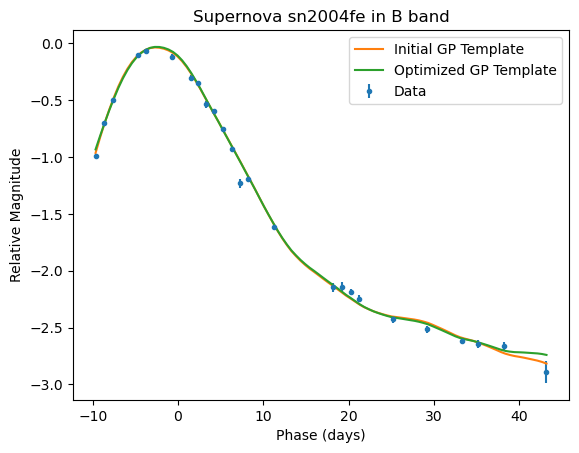

In [8]:
# Plotting data for a SN along with its initial GP fit and its optimized GP fit

plt.errorbar(all_sne[name][band]['x'],
             all_sne[name][band]['y'],
             yerr = all_sne[name][band]['yerr'],
            fmt = '.',
            label = 'Data')
plt.plot(all_sne[name][band]['t'],
         all_sne[name][band]['mu_init']+
         all_sne[name][band]['tmpl_t'],
         '-',
        label = 'Initial GP Template')
plt.plot(all_sne[name][band]['t'],
         all_sne[name][band]['mu_opt']+
         all_sne[name][band]['tmpl_t'],
         '-',
        label = 'Optimized GP Template')
plt.title('Supernova %s in %s band'%(name, band))
plt.xlabel('Phase (days)')
plt.ylabel('Relative Magnitude')
plt.legend()

In [9]:
# choose the time of maximum based on the maximum of the GP fit: Vgp_JDVmax
t_max_based_on_GP_opt = (all_sne[name][band]['t'][np.argmax(all_sne[name][band]['mu_opt']+
                                                            all_sne[name][band]['tmpl_t'])])

#check if t_max_based_on_GP_opt is not more than 5 days from the original JDVmax:
if np.abs(t_max_based_on_GP_opt)>5:
    print('No data closer than 5 days to the peak')

# Find the relative magnitude of the GP fit at the Vgp_JDVmax: M_X_gp_relative
rel_mag_max_based_on_GP_opt = (all_sne[name][band]['mu_opt'][np.argmax(all_sne[name][band]['mu_opt']+
                                                            all_sne[name][band]['tmpl_t'])]+
                              all_sne[name][band]['tmpl_t'][np.argmax(all_sne[name][band]['mu_opt']+
                                                            all_sne[name][band]['tmpl_t'])])
# Find the GP error at Vgp_JDVmax
error_max_based_on_GP_opt = (all_sne[name][band]['mu_std_opt'][np.argmax(all_sne[name][band]['mu_opt']+
                                                            all_sne[name][band]['tmpl_t'])])

# Find the magnitude of the closest data point to the maximum of the GP fit
y_mag_closest = all_sne[name][band]['y_mag'][np.argmin(np.abs(all_sne[name][band]['x']-t_max_based_on_GP_opt))]

# Find the relative magnitude of the closest data point to the maximum of the GP fit
rel_mag_closest = all_sne[name][band]['y'][np.argmin(np.abs(all_sne[name][band]['x']-t_max_based_on_GP_opt))]

# Find how much the relative magnitude is off from the apparent magnitude
mag_offset = y_mag_closest + rel_mag_closest

# Save All SNe Peak Magnitudes and Errors

## First save all SNe peak magnitude and errors in the original all_sne file

In [10]:
# Following the example above, we now save peak magnitude and error for all SNe in all bands

for s, sn in enumerate(all_sne_names):
    for b in bands_w_p:

        if not b in all_sne[sn].keys():
            continue
        if (not 'mu_opt' in all_sne[sn][b].keys()):
            # print('%s in %s/%s bands: No successful GP fits.'%(sn, b_c[0], b_c[1]))
            continue
        t_max_based_on_GP_opt = (all_sne[sn][b]['t'][np.argmax(all_sne[sn][b]['mu_opt']+
                                                             all_sne[sn][b]['tmpl_t'])])
        rel_mag_max_based_on_GP_opt = (all_sne[sn][b]['mu_opt'][np.argmax(all_sne[sn][b]['mu_opt']+
                                                        all_sne[sn][b]['tmpl_t'])]+
                          all_sne[sn][b]['tmpl_t'][np.argmax(all_sne[sn][b]['mu_opt']+
                                                        all_sne[sn][b]['tmpl_t'])])
        error_max_based_on_GP_opt = (all_sne[sn][b]['mu_std_opt'][np.argmax(all_sne[sn][b]['mu_opt']+
                                                            all_sne[sn][b]['tmpl_t'])])

        #check if t_max_based_on_GP_opt is not more than 5 days from the original JDVmax:
        if (np.abs(t_max_based_on_GP_opt)>5):
            # print('%s in %s/%s bands: No data closer than 5 days to the peak'%(sn, b_c[0], b_c[1]))
            continue

        # Find the magnitude of the closest data point to the maximum of the GP fit
        y_mag_closest = all_sne[sn][b]['y_mag'][np.argmin(np.abs(all_sne[sn][b]['x']-t_max_based_on_GP_opt))]

        # Find the relative magnitude of the closest data point to the maximum of the GP fit
        rel_mag_closest = all_sne[sn][b]['y'][np.argmin(np.abs(all_sne[sn][b]['x']-t_max_based_on_GP_opt))]

        # Find how much the relative magnitude is off from the apparent magnitude
        mag_offset = y_mag_closest + rel_mag_closest

        # Find the apparent magnitude of the GP fit peaks using the offset
        mag_max_based_on_GP_opt = mag_offset - rel_mag_max_based_on_GP_opt


        all_sne[sn]['M_%s_gp'%(b)] = mag_max_based_on_GP_opt 
        all_sne[sn]['M_%s_gp_err'%(b)] = rel_mag_max_based_on_GP_opt 

## Save All SNe Peak magnitude and errors in a Pandas DataFrame

In [18]:
# Creating a table of all or a subset of peak magnitudes and errors for all SNe
# A 2-dimentional array to save all SNe peak magnitudes and errors
all_colors = np.ones((len(all_sne_names), len(bands_w_p)*2))*np.nan

# iterating over all SNe and all colors to collect them in all_colors
column_names = []
for s, sn in enumerate(all_sne_names):
    
    for b, band in enumerate(bands_w_p):
        if s == 0:
            column_names.append('M_%s_gp'%(band))
            column_names.append('M_%s_gp_err'%(band))
        if 'M_%s_gp'%(band) in list(all_sne[sn].keys()):
            all_colors[s, 2*b] = np.round(all_sne[sn]['M_%s_gp'%(band)], 3)
            all_colors[s, 2*b+1] = np.round(all_sne[sn]['M_%s_gp_err'%(band)], 3)
            
            
# Put all the data in a dataframe
df = pd.DataFrame(data=all_colors,
                  columns= column_names,
                  index = all_sne_names)

# if you want to save a subset of bands, change it here:
subset_bands = False
if subset_bands:
    selected_columns = []
    for band in bands_w_p:
        # Remove these bands
        if band in ['w1', 'w2', 'm2']:
            continue
            
        # Or remove bands that have less than n = 30 SNe
        n = 30
        if len(df)-np.sum(np.isnan(df['M_%s_gp'%(band)].values))> n:
            selected_columns.append('M_%s_gp'%(band))
            selected_columns.append('M_%s_gp_err'%(band))
else:
    selected_columns = column_names

# Remove all rows and columns where all values are nan
df = df.dropna(axis = 0, how = 'all')
df = df.dropna(axis = 1, how = 'all')

# Replace Nans with -
df.fillna('-', inplace=True)

# save the data frame as a latex longtable
df[selected_columns].to_latex(buf=output_directory + "all_SNe_peak_mag_err.tex",
                              columns = selected_columns,
                              longtable=True)

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_10019/2117113157.py:48: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df[selected_columns].to_latex(buf=output_directory + "all_SNe_peak_mag_err.tex",


# Save All SNe Peak Colors

## Count number of SNe per color, remove colors with no values

In [44]:
# Count number of SNe per color, remove colors with no values
combo_color_names = []
bands_combo_counted = []
for b_c in bands_combo:
    count = 0
    for sn in all_sne_names:
        if ('M_%s_gp'%(b_c[0]) in list(all_sne[sn].keys())) and ('M_%s_gp'%(b_c[1]) in list(all_sne[sn].keys())):
            count += 1
    if count != 0:
        combo_color_names.append('%s-%s'%(b_c[0], b_c[1]))
        bands_combo_counted.append(b_c)


## Creating a table of all or a subset of peak colors for all SNe

In [46]:
# Creating a table of all or a subset of peak colors for all SNe
# A 2-dimentional array to save all SNe colors
all_colors = np.ones((len(all_sne_names), len(bands_combo_counted)))*np.nan

# iterating over all SNe and all colors to collect them in all_colors

for s, sn in enumerate(all_sne_names):
    for b, b_c in enumerate(bands_combo_counted):
        
        if ('M_%s_gp'%(b_c[0]) in list(all_sne[sn].keys())) and ('M_%s_gp'%(b_c[1]) in list(all_sne[sn].keys())):
            all_colors[s, b] = np.round(all_sne[sn]['M_%s_gp'%(b_c[0])]-
                                        all_sne[sn]['M_%s_gp'%(b_c[1])],
                                        2)
            
# Put all the data in a dataframe
df = pd.DataFrame(data=all_colors,
                  columns= combo_color_names,
                  index = all_sne_names)

# if you want to save a subset of colors, change it here:
subset_color = False
if subset_color:
    selected_colors = []
    for col in df.columns:
        # Remove these colors
        if col in ['B-R', 'B-I', 'V-ip', 'V-rp', 'R-I']:
            continue
            
        # Or remove colors that have less than n = 30 values
        n = 30
        if len(df)-np.sum(np.isnan(df[col].values))> n:
            if 'p' in col:
                col_ = col#.replace('p', "'")
            else:
                col_ = col

            selected_colors.append(col_)
            print('color %s has %i values.'%(col, len(df)-np.sum(np.isnan(df[col].values))))
else:
    selected_colors = combo_color_names

# Remove all rows and columns where all values are nan
df = df.dropna(axis = 0, how = 'all')
df = df.dropna(axis = 1, how = 'all')

# Replace Nans with -
df.fillna('-', inplace=True)

# save the data frame as a latex longtable
df[selected_colors].to_latex(buf=output_directory + "all_SNe_peak_colors.tex",
                             columns = selected_colors,
                            longtable=True)

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_10019/1300798694.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df[selected_colors].to_latex(buf=output_directory + "all_SNe_peak_colors.tex",


## Collecting peak colors per subtype

In [47]:
# Collecting peak colors per subtype (all_colors_per_subtype)

selected_colors = []
all_colors_per_subtype = {'IIb':{}, 
                       'Ib':{}, 
                       'Ibn':{}, 
                       'Ic':{}, 
                       'Ic-bl':{}, 
                       'Ib-c':{}}

# You can select a subset of colors instead of combo_color_names
selected_cols = combo_color_names


for col in selected_cols:
    
    for sn in df.index.values:
        if df[df.index == sn][col].values[0] != '-':
            tp = all_sne[sn]['type']
            if tp in all_colors_per_subtype.keys():
                try:
                    # if all_colors_per_subtype[tp][col] is already defined, just append the new 
                    # color value
                    all_colors_per_subtype[tp][col].append(df[df.index == sn][col].values[0])
                except:
                    # if all_colors_per_subtype[tp][col] is not defined, define it and then
                    # append the new color value
                    all_colors_per_subtype[tp][col] = []
                    all_colors_per_subtype[tp][col].append(df[df.index == sn][col].values[0])
                    

## Collecting peak colors mean and std for all SNe

In [53]:
# A 2-dimentional array to save all SNe peak color mean and std per subtype
all_colors_mean_std_per_sne = np.ones((len(combo_color_names), len(types)*2))*np.nan
# all_colors_mean_std_per_type_list = []

In [55]:
# Fill in the 2D array for peak color mean and std per subtype
column_names = []
for c, color in enumerate(combo_color_names):
    for t, tp in enumerate(types):
        if c == 0:
            column_names.append(tp+', mean')
            column_names.append(tp+', std')
        if color in all_colors_per_subtype[tp].keys():
            if len(all_colors_per_subtype[tp][color])>1:
                mean_ = np.nanmean(all_colors_per_subtype[tp][color])
                std_ = np.nanstd(all_colors_per_subtype[tp][color])
                tmp.append('$'+
                           str(np.round(mean_,2))+
                            " \pm "+ 
                           str(np.round(std_, 2))+'$')
                all_colors_mean_std_per_sne[c, 2*t] = mean_
                all_colors_mean_std_per_sne[c, 2*t+1] = std_


In [56]:
df2 = pd.DataFrame(data=all_colors_mean_std_per_sne,
                  columns= column_names,
                  index = combo_color_names)

In [372]:
df2 = df2.dropna(axis = 0, how = 'all')

In [373]:
df2 = df2.dropna(axis = 1, how = 'all')

In [374]:
df2.fillna('-', inplace=True)

In [376]:
df2.to_latex(buf=output_directory + "all_SNe_peak_mean_std_colors_versus_V_per_type.tex",
                             columns = df2.columns,
                            longtable=True)

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_15177/2742009407.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df2.to_latex(buf=output_directory + "all_SNe_peak_mean_std_colors_versus_V_per_type.tex",
